In [3]:
# %% [markdown]
"""
# Consistency Regularization for Semi-Supervised Learning

In this notebook we implement a simple consistency regularization method:
- We generate a synthetic binary classification dataset.
- We treat a small subset as labeled and the remaining as unlabeled.
- For unlabeled data, we create perturbed (augmented) versions by adding random noise.
- We define a neural network model.
- The training loss is a combination of:
  - **Supervised loss** on labeled data (cross-entropy loss).
  - **Consistency loss** on unlabeled data (mean squared error between the model’s predictions on the original and perturbed inputs).
- Finally, we monitor training performance and visualize the decision boundaries.

Let's begin by importing libraries and generating the data.
"""

"\n# Consistency Regularization for Semi-Supervised Learning\n\nIn this notebook we implement a simple consistency regularization method:\n- We generate a synthetic binary classification dataset.\n- We treat a small subset as labeled and the remaining as unlabeled.\n- For unlabeled data, we create perturbed (augmented) versions by adding random noise.\n- We define a neural network model.\n- The training loss is a combination of:\n  - **Supervised loss** on labeled data (cross-entropy loss).\n  - **Consistency loss** on unlabeled data (mean squared error between the model’s predictions on the original and perturbed inputs).\n- Finally, we monitor training performance and visualize the decision boundaries.\n\nLet's begin by importing libraries and generating the data.\n"

In [4]:
# %% [code]
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
#plt.style.use('seaborn-whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
# %% [markdown]
"""
# Cell 2: Generate Synthetic Dataset

We create a synthetic 2D dataset (for easy visualization) with two classes.
We simulate a semi-supervised scenario by labeling only a small fraction of the data.
"""

# %% [code]
# Generate a synthetic binary classification dataset
n_samples = 2000
X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, class_sep=1.5, flip_y=0.05, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In our semi-supervised setting, only a small subset of the training data is labeled.
label_ratio = 0.2  # 20% of training samples are labeled
n_train = X_train.shape[0]
n_labeled = int(label_ratio * n_train)
labeled_indices = np.random.choice(n_train, n_labeled, replace=False)

# Create label arrays: labeled samples keep true labels; unlabeled samples are set to -1.
y_train_semi = -np.ones(n_train, dtype=int)
y_train_semi[labeled_indices] = y_train[labeled_indices]

print(f"Total training samples: {n_train}")
print(f"Labeled training samples: {n_labeled}")

Total training samples: 1600
Labeled training samples: 320


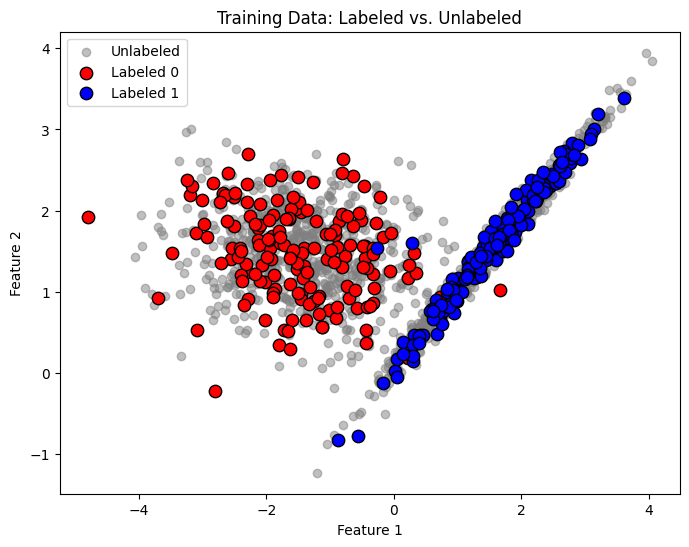

In [6]:
# %% [markdown]
"""
# Cell 3: Visualize the Data

We visualize the training data. Labeled samples are colored by class while unlabeled samples are gray.
"""

# %% [code]
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train_semi == -1, 0], X_train[y_train_semi == -1, 1], color='gray', alpha=0.5, label='Unlabeled')
for cl, col in zip([0, 1], ['red', 'blue']):
    plt.scatter(X_train[y_train_semi == cl, 0], X_train[y_train_semi == cl, 1], color=col, edgecolor='k', s=80, label=f'Labeled {cl}')
plt.title("Training Data: Labeled vs. Unlabeled")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [7]:
# %% [markdown]
"""
# Cell 4: Define PyTorch Dataset with Data Augmentation

We create a custom PyTorch dataset class. For unlabeled data, we return both the original sample and
an augmented version (by adding small Gaussian noise). For labeled data, the augmentation is optional.
"""

# %% [code]
class SemiSupervisedDataset(Dataset):
    def __init__(self, X, y, is_train=True, augment=False, noise_std=0.1):
        """
        Args:
            X: Feature array.
            y: Labels, with -1 indicating unlabeled samples.
            is_train: Whether dataset is for training.
            augment: Whether to return an augmented version of the input.
            noise_std: Standard deviation of Gaussian noise for augmentation.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment
        self.noise_std = noise_std
        self.is_train = is_train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        label = self.y[idx]
        if self.augment:
            # Create an augmented version by adding Gaussian noise
            noise = torch.randn_like(x) * self.noise_std
            x_aug = x + noise
            return x, x_aug, label
        else:
            return x, label

# Create dataset and dataloaders
train_dataset = SemiSupervisedDataset(X_train, y_train_semi, is_train=True, augment=True, noise_std=0.1)
test_dataset = SemiSupervisedDataset(X_test, y_test, is_train=False, augment=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# %% [markdown]
"""
# Cell 5: Define the Neural Network Model

We define a simple feedforward neural network for binary classification.
The network will output logits for each class.
"""

# %% [code]
class SimpleNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_classes=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

model = SimpleNN(input_dim=2, hidden_dim=64, num_classes=2)
print(model)


SimpleNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
# %% [markdown]
"""
# Cell 6: Define Loss Functions and Optimizer

The training loss is a combination of:
1. **Supervised Loss:** Cross-entropy loss computed on labeled samples.
2. **Consistency Loss:** Mean squared error between the predictions for the original and augmented
   versions of unlabeled data.

We use a weight (lambda) to balance the consistency loss.
"""

# %% [code]
# Define loss functions
supervised_criterion = nn.CrossEntropyLoss()
consistency_criterion = nn.MSELoss()

# Weight for the consistency loss term
lambda_consistency = 0.5

optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Loss: 0.4852, Test Acc: 0.9375
Epoch 2/50, Loss: 0.2145, Test Acc: 0.9375
Epoch 3/50, Loss: 0.1227, Test Acc: 0.9400
Epoch 4/50, Loss: 0.1059, Test Acc: 0.9525
Epoch 5/50, Loss: 0.0997, Test Acc: 0.9575
Epoch 6/50, Loss: 0.1096, Test Acc: 0.9600
Epoch 7/50, Loss: 0.0957, Test Acc: 0.9575
Epoch 8/50, Loss: 0.0949, Test Acc: 0.9575
Epoch 9/50, Loss: 0.0896, Test Acc: 0.9575
Epoch 10/50, Loss: 0.0933, Test Acc: 0.9575
Epoch 11/50, Loss: 0.0834, Test Acc: 0.9575
Epoch 12/50, Loss: 0.0906, Test Acc: 0.9575
Epoch 13/50, Loss: 0.0855, Test Acc: 0.9575
Epoch 14/50, Loss: 0.0873, Test Acc: 0.9575
Epoch 15/50, Loss: 0.0938, Test Acc: 0.9575
Epoch 16/50, Loss: 0.0942, Test Acc: 0.9575
Epoch 17/50, Loss: 0.0882, Test Acc: 0.9575
Epoch 18/50, Loss: 0.1013, Test Acc: 0.9575
Epoch 19/50, Loss: 0.0844, Test Acc: 0.9575
Epoch 20/50, Loss: 0.0853, Test Acc: 0.9575
Epoch 21/50, Loss: 0.0906, Test Acc: 0.9550
Epoch 22/50, Loss: 0.0845, Test Acc: 0.9575
Epoch 23/50, Loss: 0.0889, Test Acc: 0.95

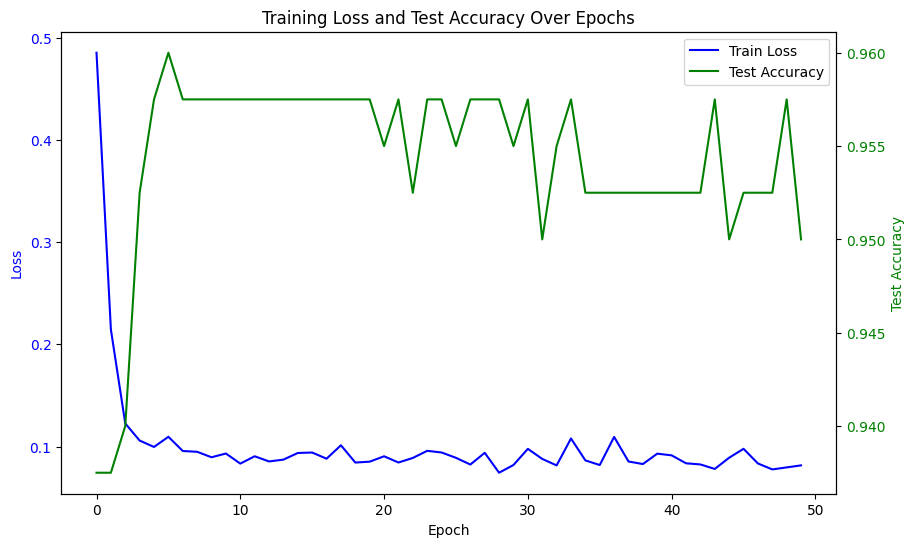

In [10]:
# %% [markdown]
"""
# Cell 7: Training Loop with Consistency Regularization

For each batch, we process the labeled and unlabeled data:
- For labeled data (where label != -1), we compute the cross-entropy loss.
- For unlabeled data (label == -1), we compute the consistency loss between the model’s predictions on the original and augmented inputs.
- The total loss is the sum of the supervised loss (only computed for labeled examples) and the consistency loss (scaled by lambda).
"""

# %% [code]
num_epochs = 50
train_losses = []
test_accuracies = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        # Unpack batch: for each sample, we get original x, augmented x_aug, and label.
        x, x_aug, labels = batch

        # Forward pass for both original and augmented versions
        logits = model(x)
        logits_aug = model(x_aug)

        # Create masks for labeled and unlabeled data
        labeled_mask = (labels != -1)
        unlabeled_mask = (labels == -1)

        loss_supervised = 0.0
        if labeled_mask.sum() > 0:
            # Compute supervised loss for labeled data only
            loss_supervised = supervised_criterion(logits[labeled_mask], labels[labeled_mask])

        loss_consistency = 0.0
        if unlabeled_mask.sum() > 0:
            # For unlabeled data, use softmax predictions
            pred_orig = F.softmax(logits[unlabeled_mask], dim=1)
            pred_aug = F.softmax(logits_aug[unlabeled_mask], dim=1)
            loss_consistency = consistency_criterion(pred_orig, pred_aug)

        loss = loss_supervised + lambda_consistency * loss_consistency

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Record and print average epoch loss
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set (using model predictions without augmentation)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_test, labels_test in test_loader:
            logits_test = model(x_test)
            preds = torch.argmax(logits_test, dim=1)
            all_preds.append(preds.numpy())
            all_labels.append(labels_test.numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    test_acc = accuracy_score(all_labels, all_preds)
    test_accuracies.append(test_acc)

    model.train()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}")

# Plot training loss and test accuracy curves
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(train_losses, color='blue', label='Train Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(test_accuracies, color='green', label='Test Accuracy')
ax2.set_ylabel("Test Accuracy", color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title("Training Loss and Test Accuracy Over Epochs")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

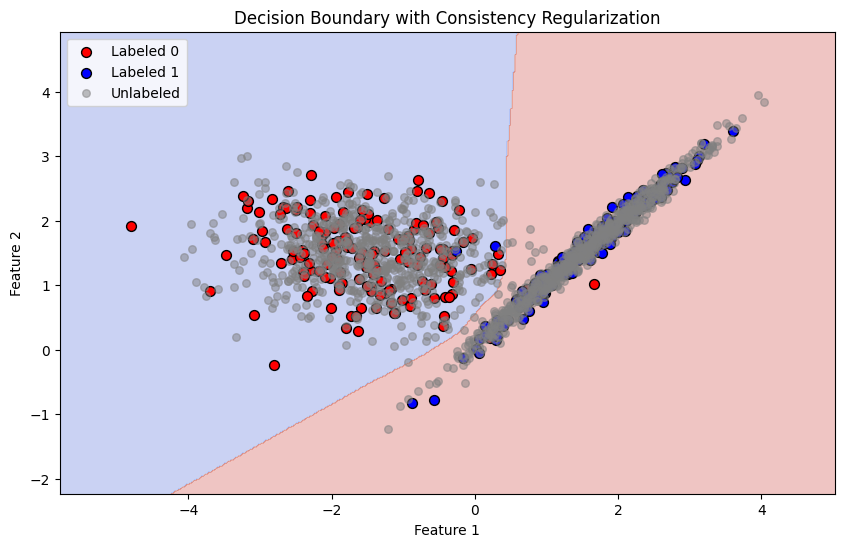

In [11]:
# %% [markdown]
"""
# Cell 8: Visualize Decision Boundary

After training, we visualize the decision boundary on the 2D feature space.
We plot the predictions of the model for a grid of points and overlay the training data.
"""

# %% [code]
# Create a grid for visualization
h = 0.02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Convert grid to tensor and get model predictions
grid = np.c_[xx.ravel(), yy.ravel()]
model.eval()
with torch.no_grad():
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    logits_grid = model(grid_tensor)
    preds_grid = torch.argmax(F.softmax(logits_grid, dim=1), dim=1).numpy()
preds_grid = preds_grid.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, preds_grid, alpha=0.3, cmap=plt.cm.coolwarm)
# Overlay training points (colored by true label for labeled data, gray for unlabeled)
for cl, col in zip([0, 1], ['red', 'blue']):
    plt.scatter(X_train[y_train_semi == cl, 0], X_train[y_train_semi == cl, 1], color=col, edgecolor='k', s=50, label=f'Labeled {cl}')
plt.scatter(X_train[y_train_semi == -1, 0], X_train[y_train_semi == -1, 1], color='gray', s=30, label='Unlabeled', alpha=0.5)
plt.title("Decision Boundary with Consistency Regularization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [12]:


# %% [markdown]
"""
# Cell 9: Summary

In this notebook, we implemented a semi-supervised learning approach using consistency regularization. Key points include:
- **Data Augmentation:** For unlabeled data, we added Gaussian noise to generate perturbed inputs.
- **Consistency Loss:** We minimized the difference (MSE) between the model’s softmax outputs for the original and perturbed inputs.
- **Combined Loss:** The final loss was a sum of the supervised cross-entropy loss (on labeled data) and the consistency loss (on unlabeled data), weighted by a hyperparameter.
- We monitored training loss and test accuracy, and visualized the decision boundary in the feature space.

This method encourages the model to learn robust representations that are invariant to small perturbations—a key idea in modern semi-supervised learning.

Feel free to experiment further by adjusting the augmentation strength, the lambda weight, or exploring other perturbation methods.
"""


'\n# Cell 9: Summary\n\nIn this notebook, we implemented a semi-supervised learning approach using consistency regularization. Key points include:\n- **Data Augmentation:** For unlabeled data, we added Gaussian noise to generate perturbed inputs.\n- **Consistency Loss:** We minimized the difference (MSE) between the model’s softmax outputs for the original and perturbed inputs.\n- **Combined Loss:** The final loss was a sum of the supervised cross-entropy loss (on labeled data) and the consistency loss (on unlabeled data), weighted by a hyperparameter.\n- We monitored training loss and test accuracy, and visualized the decision boundary in the feature space.\n\nThis method encourages the model to learn robust representations that are invariant to small perturbations—a key idea in modern semi-supervised learning.\n\nFeel free to experiment further by adjusting the augmentation strength, the lambda weight, or exploring other perturbation methods.\n'